# Classification of hand-written digits

Start by loading the tensorflow package

In [121]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gzip
import os
from six.moves import urllib
tf.logging.set_verbosity(tf.logging.ERROR)

The following functions are needed to load the data. Just execute the cell below, do not bother about all the details.

In [122]:
SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10
def maybe_download(filename):
  """Download the data from Yann's website, unless it's already here."""
  if not tf.gfile.Exists(WORK_DIRECTORY):
    tf.gfile.MakeDirs(WORK_DIRECTORY)
  filepath = os.path.join(WORK_DIRECTORY, filename)
  if not tf.gfile.Exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
      size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
  return filepath


def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].
  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data


def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)    
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)    
    # one hot encode
    onehot_encoded = list()
    for value in labels:
        letter = [0 for _ in range(0,NUM_LABELS)]
        letter[value] = 1
        onehot_encoded.append(letter)    
    labels_onehot_encoded  = np.array(onehot_encoded)
    return labels_onehot_encoded

Download, extract and load the mnist data

In [123]:
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

# Dataset size
train_size = train_labels.shape[0]
test_size = test_labels.shape[0]

# Normalize the data
train_data = train_data/255.0
test_data = test_data/255.0

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### The model

Define placeholders for the data. The input data Xim are $28\times 28$ pixels grayscale images. The first dimension None will be the number of data points, determined when launching the graph. This placeholder is flattend into a matrix with $28\times 28=784$ columns, where each colum represents one pixel. The placeholder for the output data Y is a one hot encoding representing the 10 different classes. One hot encoding for the class "0" is [1 0 0 0 0 0 0 0 0 0], for class "1" is [0 1 0 0 0 0 0 0 0 0] and so forth.

In [124]:
# The placeholder for the input
Xim = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28, 1])

# Number of data points (in the present batch)
batchsize = tf.shape(Xim)[[0]]

# Flatten the data into a matrix with  28 x 28 = 784 columns
X = tf.reshape(tensor = Xim, shape = [batchsize,784 ])

# The placeholder of the output. 
Y = tf.placeholder(dtype = tf.float32, shape = [None, 10])


Define the weights of the network

In [125]:
# The weights of dimension W[784,10]
#W = tf.Variable(initial_value = tf.zeros([784, 10]))

# The offset vector of dimension b[10]
#b = tf.Variable(initial_value = tf.zeros(10))

In [138]:
M = 200 # Number of hidden units
#W1 = tf.Variable(initial_value = tf.truncated_normal([784, M],stddev = 0.1))
W1 = tf.Variable(initial_value = tf.zeros([784, M]))
b1 = tf.Variable(initial_value = tf.zeros(M))
W2 = tf.Variable(initial_value = tf.truncated_normal([M, 10],stddev = 0.1))
#W2 = tf.Variable(initial_value = tf.zeros([M, 10]))
b2 = tf.Variable(initial_value = tf.zeros(10))

Define the actual network model

In [139]:
# The network model
#P = tf.nn.softmax(tf.matmul(X, W) + b)

In [140]:
H = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
P = tf.nn.softmax(tf.matmul(H, W2) + b2)

### The training 
Define the loss function and the training parameters

In [141]:
# The loss function: Compute the cross-entropy
cross_entropy = -tf.reduce_mean(tf.reduce_sum(Y * tf.log(P), reduction_indices=1))

# Define the training
gamma = 0.5 # The learning rate
train_step = tf.train.GradientDescentOptimizer(gamma).minimize(cross_entropy)

Accuracy of the trained model. 0 is worst and 1 is the best.
These lines are for evaluating the performance. Don't bother to much about them!

In [142]:
prediction = tf.argmax(P, 1) # In each row of Q, determine the index of the column with highest probability
true = tf.argmax(Y, 1) 
correct_prediction = tf.equal(true, prediction) # Compare with true labels. TRUE if correct, FALSE if not.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Launch the graph and train it!

In [143]:
# Create session and initialize  variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Initialize the test and training error resutls
test_accuracy = []
test_cross_entropy = []
test_iter = []
train_accuracy = []
train_cross_entropy = []
train_iter = []

BATCH_SIZE = 100 # Batch size
NUM_ITERATIONS = 2000 # Total number of iterations
iter_in_one_epoch = np.floor_divide(train_size,BATCH_SIZE) # Number of iterations in each epoch
# The main training loop
for t in range(0, NUM_ITERATIONS+1):
    
    # The iteration number in the present epoch
    j = (t%iter_in_one_epoch)
    
    # If a new epoch, reshuffle the data indices
    if j == 0:
        train_ind = np.random.choice(train_size,size=train_size, replace=False)        
        
    # Compute the indices of the batch
    offset = j*BATCH_SIZE
    batch_ind = train_ind[offset:(offset+BATCH_SIZE)]
    
    # Extract a batch with BATCH_SIZE images and labels
    batch_xs = train_data[batch_ind, ...]
    batch_ys = train_labels[batch_ind,]        
    
    # Do one gradient setp
    sess.run(train_step,feed_dict = {Xim: batch_xs, Y: batch_ys})

    # Evaluate the performance on training data
    # These lines are for evaluating the performance. Don't bother too much about them!

    if (t%10 == 0):        
        # Evaluate on test data
        train_tmp = sess.run([accuracy,cross_entropy], feed_dict = {Xim: batch_xs, Y: batch_ys})
        train_accuracy.append(train_tmp[0])
        train_cross_entropy.append(train_tmp[1])
        train_iter.append(t)

    # Evaluate the performance on training data at every 100th itertation
    # These lines are for evaluating the performance. Don't bother too much about them!

    if (t%100==0):
        # Evaluate on test data
        test_tmp = sess.run([accuracy,cross_entropy], feed_dict = {Xim: test_data, Y: test_labels})
        test_accuracy.append(test_tmp[0])
        test_cross_entropy.append(test_tmp[1])
        test_iter.append(t)

        # Also print iteration number and prediction accuracy
        print("Step %d: train acc. %.2f  train cross-entropy %.2f test acc. %.3f  test cross-entropy %.3f" % (t,train_tmp[0],train_tmp[1],test_tmp[0],test_tmp[1]))



Step 0: train acc. 0.13  train cross-entropy 2.75 test acc. 0.101  test cross-entropy 2.781
Step 100: train acc. 0.90  train cross-entropy 0.45 test acc. 0.872  test cross-entropy 0.494
Step 200: train acc. 0.90  train cross-entropy 0.33 test acc. 0.894  test cross-entropy 0.381
Step 300: train acc. 0.96  train cross-entropy 0.23 test acc. 0.898  test cross-entropy 0.344
Step 400: train acc. 0.94  train cross-entropy 0.24 test acc. 0.904  test cross-entropy 0.322
Step 500: train acc. 0.96  train cross-entropy 0.17 test acc. 0.915  test cross-entropy 0.296
Step 600: train acc. 0.94  train cross-entropy 0.22 test acc. 0.920  test cross-entropy 0.286
Step 700: train acc. 0.88  train cross-entropy 0.41 test acc. 0.919  test cross-entropy 0.283
Step 800: train acc. 0.93  train cross-entropy 0.36 test acc. 0.922  test cross-entropy 0.273
Step 900: train acc. 0.93  train cross-entropy 0.18 test acc. 0.924  test cross-entropy 0.260
Step 1000: train acc. 0.93  train cross-entropy 0.21 test acc.

### The evaluation

The remaining code produces the plots needed to evaluate the training and prediction

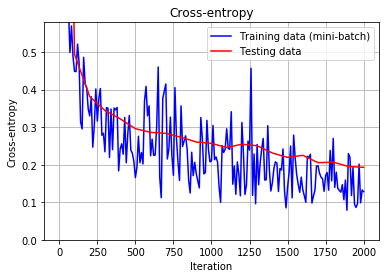

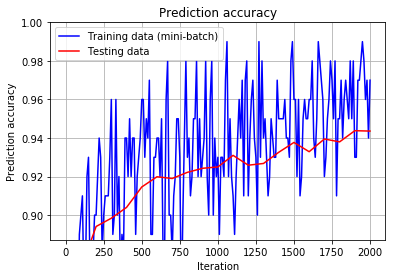

In [144]:
# Do the plot of cross entropy
plt.plot(train_iter, train_cross_entropy,'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_cross_entropy,'r-', label='Testing data')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy')
plt.ylim([0,min(test_cross_entropy)*3])
plt.title('Cross-entropy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# Do the plot of accuracy
plt.plot(train_iter, train_accuracy,'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_accuracy,'r-', label='Testing data')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1-(1-test_accuracy[-1])*2,0),1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [145]:
# Evaluate on all test data
tmp = sess.run([prediction,P], feed_dict = {Xim: test_data})
test_pred = tmp[0]
test_P = tmp[1]
test_true = sess.run(true, feed_dict = {Y: test_labels})

# Close the session
sess.close()

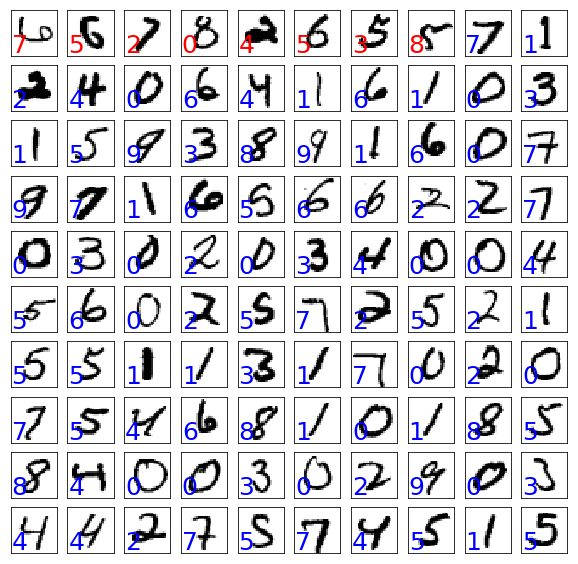

In [146]:
# Extract 100 random test images
batch_test_ind = np.random.choice(test_size,100)
batch_test_ind_wrong_first = batch_test_ind[np.argsort(test_true[batch_test_ind]==test_pred[batch_test_ind])]

# Do the plot of the images
num_rows = 10
num_cols = 10
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, i_im in enumerate(batch_test_ind_wrong_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[i_im,:,:,0], cmap=plt.cm.binary)    
    if test_pred[i_im]==test_true[i_im]:
          plt.text(0, 25, test_pred[i_im], fontsize=25, color='blue')
    else:
          plt.text(0, 25, test_pred[i_im], fontsize=25, color='red')    
                  
plt.show()
